In [1]:
import numpy as np
import pandas as pd
import warnings
import datetime
import time
warnings.simplefilter('ignore')
import math
from statistics import mean
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.metrics import mean_squared_error


#from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
import category_encoders as ce

import lightgbm as lgb

In [2]:
status = pd.read_csv('../../../status.csv')

#statusのyear, month, dayを結合してdatetime型に
status['date'] = status['year'].astype(str) + '/' + status['month'].astype(str).str.zfill(2).astype(str) + '/' + status['day'].astype(str).str.zfill(2).astype(str) + '/' + status['hour'].astype(str).str.zfill(2).astype(str)
status['date'] = pd.to_datetime(status['date'], format='%Y/%m/%d/%H', infer_datetime_format=True)

#曜日を追加するための関数を定義
def get_weekday_jp(dt):
    w_list = ['月曜日', '火曜日', '水曜日', '木曜日', '金曜日', '土曜日', '日曜日']
    return(w_list[dt.weekday()])

#dateから曜日情報を取得
status["weekday"] = status["date"].apply(get_weekday_jp)

main_df = status[['date','hour', 'station_id', 'bikes_available', 'weekday', 'day']]

#カテゴリ変数をダミー変数化
main_df = pd.get_dummies(main_df)

In [3]:
stationid_set = [0, 15, 32, 36, 38, 40, 43, 49, 54, 56] 

In [5]:
for station_id in stationid_set:
    train_X = main_df[main_df['station_id'] == station_id]
    train_lag = train_X[train_X['date'] < '2013-10-01']['bikes_available']

    train_learn = train_X[train_X['date'] < '2013-10-01']
    train_learn = train_learn[train_learn['date'] >= '2013-09-02']
    
    i = 1
    while i < 25:
        row_name = "lag_" + str(i) + "hour"
        set = train_lag[24-i:720-i]
        train_learn[row_name] = set.values
        i += 1
    i = 0    
    
    train_learn_y = train_learn["bikes_available"]
    train_learn_x = train_learn.drop("station_id",axis=1)
    train_learn_x = train_learn_x.drop("date",axis=1)
    train_learn_x = train_learn_x.drop("bikes_available",axis=1)    

    train_lightgbm_set = lgb.Dataset(train_learn_x, train_learn_y)

    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "verbose" : -1
    }

    lgb_model_24 = lgb.train(
        params = params,
        train_set = train_lightgbm_set,
        valid_sets = [train_lightgbm_set, train_lightgbm_set],
        num_boost_round = 300,
        early_stopping_rounds=10,
        verbose_eval=5
    )

    pred_lightgbn_24 = lgb_model_24.predict(train_learn_x)    
    train_learn['predict_24'] = pred_lightgbn_24
    train_file_name = "lgb_24_predict/lgb_train_stationid" + str(station_id) + "_201309.csv" 
    train_learn.to_csv(train_file_name)
    
    test_lag = main_df[main_df['station_id'] == station_id][main_df['date'] < '2013-10-01']
    test_lag = test_lag[test_lag['date'] >= '2013-09-30']['bikes_available']     
    test = main_df[main_df['station_id'] == station_id][main_df['date'] < '2013-10-08']
    test = test[test['date'] >= '2013-10-01']
    test_y = test["bikes_available"]
    test_x = test.drop("station_id",axis=1)
    test_x = test_x.drop("date",axis=1)
    test_x = test_x.drop("bikes_available",axis=1)    

    pred_lightgbm_test = []
    len(pred_lightgbm_test)
    i=0
    while i < 168:
        test_x_line = test_x[i:i+1]

        lag = []
        for j in pred_lightgbm_test:
            lag.insert(0, j)

        for k in range(24 - len(pred_lightgbm_test)):
            lag.append(test_lag[23-k:24-k].values)
        s = 1
        while s < 25:
            row_name = "lag_" + str(s) + "hour"
            test_x_line[row_name] = lag[s-1]
            s += 1

        pred_lightgbm_test_lag_line = lgb_model_24.predict(test_x_line)
        pred_lightgbm_test =np.append(pred_lightgbm_test, pred_lightgbm_test_lag_line)
        i += 1

    test['predict_24'] = pred_lightgbm_test
    test_file_name = "lgb_24_predict/lgb_test_stationid" + str(station_id) + "_201309.csv" 
    test.to_csv(test_file_name)
    print(dt_now)

Training until validation scores don't improve for 10 rounds
[5]	training's rmse: 2.42855
[10]	training's rmse: 1.78667
[15]	training's rmse: 1.46332
[20]	training's rmse: 1.28601
[25]	training's rmse: 1.18324
[30]	training's rmse: 1.10769
[35]	training's rmse: 1.03
[40]	training's rmse: 0.965107
[45]	training's rmse: 0.913966
[50]	training's rmse: 0.873358
[55]	training's rmse: 0.836865
[60]	training's rmse: 0.802343
[65]	training's rmse: 0.771873
[70]	training's rmse: 0.744371
[75]	training's rmse: 0.718695
[80]	training's rmse: 0.693518
[85]	training's rmse: 0.67123
[90]	training's rmse: 0.648692
[95]	training's rmse: 0.627894
[100]	training's rmse: 0.610155
[105]	training's rmse: 0.592402
[110]	training's rmse: 0.577365
[115]	training's rmse: 0.561586
[120]	training's rmse: 0.547505
[125]	training's rmse: 0.533033
[130]	training's rmse: 0.520466
[135]	training's rmse: 0.50669
[140]	training's rmse: 0.495402
[145]	training's rmse: 0.483371
[150]	training's rmse: 0.471449
[155]	train

2022-01-11 05:05:45.201112
Training until validation scores don't improve for 10 rounds
[5]	training's rmse: 2.44775
[10]	training's rmse: 1.9256
[15]	training's rmse: 1.66124
[20]	training's rmse: 1.50261
[25]	training's rmse: 1.39257
[30]	training's rmse: 1.30649
[35]	training's rmse: 1.2225
[40]	training's rmse: 1.15527
[45]	training's rmse: 1.10185
[50]	training's rmse: 1.04389
[55]	training's rmse: 0.99989
[60]	training's rmse: 0.952117
[65]	training's rmse: 0.908904
[70]	training's rmse: 0.870559
[75]	training's rmse: 0.832244
[80]	training's rmse: 0.798699
[85]	training's rmse: 0.768289
[90]	training's rmse: 0.741295
[95]	training's rmse: 0.71343
[100]	training's rmse: 0.68549
[105]	training's rmse: 0.660167
[110]	training's rmse: 0.635742
[115]	training's rmse: 0.614628
[120]	training's rmse: 0.591701
[125]	training's rmse: 0.572043
[130]	training's rmse: 0.5536
[135]	training's rmse: 0.534163
[140]	training's rmse: 0.51636
[145]	training's rmse: 0.498887
[150]	training's rmse:

2022-01-11 05:05:45.201112
Training until validation scores don't improve for 10 rounds
[5]	training's rmse: 2.63031
[10]	training's rmse: 1.94701
[15]	training's rmse: 1.59928
[20]	training's rmse: 1.40797
[25]	training's rmse: 1.28286
[30]	training's rmse: 1.19101
[35]	training's rmse: 1.10727
[40]	training's rmse: 1.03477
[45]	training's rmse: 0.977834
[50]	training's rmse: 0.925863
[55]	training's rmse: 0.876923
[60]	training's rmse: 0.832198
[65]	training's rmse: 0.796614
[70]	training's rmse: 0.751835
[75]	training's rmse: 0.719188
[80]	training's rmse: 0.684667
[85]	training's rmse: 0.657775
[90]	training's rmse: 0.628999
[95]	training's rmse: 0.60299
[100]	training's rmse: 0.576798
[105]	training's rmse: 0.556441
[110]	training's rmse: 0.534924
[115]	training's rmse: 0.51697
[120]	training's rmse: 0.498722
[125]	training's rmse: 0.47974
[130]	training's rmse: 0.461747
[135]	training's rmse: 0.446365
[140]	training's rmse: 0.430721
[145]	training's rmse: 0.416311
[150]	training'

In [9]:
for station_id in stationid_set:
    train_X = main_df[main_df['station_id'] == station_id]
    train_lag = train_X[train_X['date'] < '2014-02-01']
    train_lag = train_lag[train_lag['date'] >= '2014-01-01']['bikes_available']
    train_learn = train_X[train_X['date'] < '2014-02-01']
    train_learn = train_learn[train_learn['date'] >= '2014-01-02']
    
    i = 1
    while i < 25:
        row_name = "lag_" + str(i) + "hour"
        set = train_lag[24-i:744-i]
        train_learn[row_name] = set.values
        i += 1
    i = 0    
    
    train_learn_y = train_learn["bikes_available"]
    train_learn_x = train_learn.drop("station_id",axis=1)
    train_learn_x = train_learn_x.drop("date",axis=1)
    train_learn_x = train_learn_x.drop("bikes_available",axis=1)    

    train_lightgbm_set = lgb.Dataset(train_learn_x, train_learn_y)

    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "verbose" : -1
    }

    lgb_model_24 = lgb.train(
        params = params,
        train_set = train_lightgbm_set,
        valid_sets = [train_lightgbm_set, train_lightgbm_set],
        num_boost_round = 300,
        early_stopping_rounds=10,
        verbose_eval=5
    )

    pred_lightgbn_24 = lgb_model_24.predict(train_learn_x)    
    train_learn['predict_24'] = pred_lightgbn_24
    train_file_name = "lgb_24_predict/lgb_train_stationid" + str(station_id) + "_201401.csv" 
    train_learn.to_csv(train_file_name)
    
    test_lag = main_df[main_df['station_id'] == station_id][main_df['date'] < '2014-02-01']
    test_lag = test_lag[test_lag['date'] >= '2014-01-31']['bikes_available']     
    test = main_df[main_df['station_id'] == station_id][main_df['date'] < '2014-02-08']
    test = test[test['date'] >= '2014-02-01']
    test_y = test["bikes_available"]
    test_x = test.drop("station_id",axis=1)
    test_x = test_x.drop("date",axis=1)
    test_x = test_x.drop("bikes_available",axis=1)    

    pred_lightgbm_test = []
    len(pred_lightgbm_test)
    i=0
    while i < 168:
        test_x_line = test_x[i:i+1]

        lag = []
        for j in pred_lightgbm_test:
            lag.insert(0, j)

        for k in range(24 - len(pred_lightgbm_test)):
            lag.append(test_lag[23-k:24-k].values)
        s = 1
        while s < 25:
            row_name = "lag_" + str(s) + "hour"
            test_x_line[row_name] = lag[s-1]
            s += 1

        pred_lightgbm_test_lag_line = lgb_model_24.predict(test_x_line)
        pred_lightgbm_test =np.append(pred_lightgbm_test, pred_lightgbm_test_lag_line)
        i += 1

    test['predict_24'] = pred_lightgbm_test
    test_file_name = "lgb_24_predict/lgb_test_stationid" + str(station_id) + "_201401.csv" 
    test.to_csv(test_file_name)
    print(dt_now)

Training until validation scores don't improve for 10 rounds
[5]	training's rmse: 2.33349
[10]	training's rmse: 1.72463
[15]	training's rmse: 1.40014
[20]	training's rmse: 1.19859
[25]	training's rmse: 1.07755
[30]	training's rmse: 0.995068
[35]	training's rmse: 0.91552
[40]	training's rmse: 0.856852
[45]	training's rmse: 0.807596
[50]	training's rmse: 0.763743
[55]	training's rmse: 0.723361
[60]	training's rmse: 0.687299
[65]	training's rmse: 0.648259
[70]	training's rmse: 0.61777
[75]	training's rmse: 0.588489
[80]	training's rmse: 0.561708
[85]	training's rmse: 0.536882
[90]	training's rmse: 0.514573
[95]	training's rmse: 0.493727
[100]	training's rmse: 0.473751
[105]	training's rmse: 0.452775
[110]	training's rmse: 0.434489
[115]	training's rmse: 0.418024
[120]	training's rmse: 0.400619
[125]	training's rmse: 0.386017
[130]	training's rmse: 0.37145
[135]	training's rmse: 0.3575
[140]	training's rmse: 0.344027
[145]	training's rmse: 0.331547
[150]	training's rmse: 0.319592
[155]	tra

FileNotFoundError: [Errno 2] No such file or directory: 'lgb_24_predict/normal/lgb_train_stationid0_201401.csv'

In [13]:
for station_id in stationid_set:
    train_X = main_df[main_df['station_id'] == station_id]
    train_lag = train_X[train_X['date'] < '2014-06-01']
    train_lag = train_lag[train_lag['date'] >= '2014-05-01']['bikes_available']
    train_learn = train_X[train_X['date'] < '2014-06-01']
    train_learn = train_learn[train_learn['date'] >= '2014-05-02']
    
    i = 1
    while i < 25:
        row_name = "lag_" + str(i) + "hour"
        set = train_lag[24-i:744-i]
        train_learn[row_name] = set.values
        i += 1
    i = 0    
    
    train_learn_y = train_learn["bikes_available"]
    train_learn_x = train_learn.drop("station_id",axis=1)
    train_learn_x = train_learn_x.drop("date",axis=1)
    train_learn_x = train_learn_x.drop("bikes_available",axis=1)    

    train_lightgbm_set = lgb.Dataset(train_learn_x, train_learn_y)

    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "verbose" : -1
    }

    lgb_model_24 = lgb.train(
        params = params,
        train_set = train_lightgbm_set,
        valid_sets = [train_lightgbm_set, train_lightgbm_set],
        num_boost_round = 300,
        early_stopping_rounds=10,
        verbose_eval=5
    )

    pred_lightgbn_24 = lgb_model_24.predict(train_learn_x)    
    train_learn['predict_24'] = pred_lightgbn_24
    train_file_name = "lgb_24_predict/lgb_test_stationid" + str(station_id) + "_201405.csv" 
    train_learn.to_csv(train_file_name)
    
    test_lag = main_df[main_df['station_id'] == station_id][main_df['date'] < '2014-06-01']
    test_lag = test_lag[test_lag['date'] >= '2014-05-31']['bikes_available']     
    test = main_df[main_df['station_id'] == station_id][main_df['date'] < '2014-06-08']
    test = test[test['date'] >= '2014-06-01']
    test_y = test["bikes_available"]
    test_x = test.drop("station_id",axis=1)
    test_x = test_x.drop("date",axis=1)
    test_x = test_x.drop("bikes_available",axis=1)    

    pred_lightgbm_test = []
    len(pred_lightgbm_test)
    i=0
    while i < 168:
        test_x_line = test_x[i:i+1]

        lag = []
        for j in pred_lightgbm_test:
            lag.insert(0, j)

        for k in range(24 - len(pred_lightgbm_test)):
            lag.append(test_lag[23-k:24-k].values)
        s = 1
        while s < 25:
            row_name = "lag_" + str(s) + "hour"
            test_x_line[row_name] = lag[s-1]
            s += 1

        pred_lightgbm_test_lag_line = lgb_model_24.predict(test_x_line)
        pred_lightgbm_test =np.append(pred_lightgbm_test, pred_lightgbm_test_lag_line)
        i += 1

    test['predict_24'] = pred_lightgbm_test
    test_file_name = "lgb_24_predict/lgb_test_stationid" + str(station_id) + "_201405.csv" 
    test.to_csv(test_file_name)
    print(dt_now)

Training until validation scores don't improve for 10 rounds
[5]	training's rmse: 2.53354
[10]	training's rmse: 2.00442
[15]	training's rmse: 1.70972
[20]	training's rmse: 1.54231
[25]	training's rmse: 1.38768
[30]	training's rmse: 1.2854
[35]	training's rmse: 1.19748
[40]	training's rmse: 1.11979
[45]	training's rmse: 1.05218
[50]	training's rmse: 0.998467
[55]	training's rmse: 0.949171
[60]	training's rmse: 0.901948
[65]	training's rmse: 0.86199
[70]	training's rmse: 0.825373
[75]	training's rmse: 0.79261
[80]	training's rmse: 0.761505
[85]	training's rmse: 0.735366
[90]	training's rmse: 0.710802
[95]	training's rmse: 0.688155
[100]	training's rmse: 0.664467
[105]	training's rmse: 0.641209
[110]	training's rmse: 0.621219
[115]	training's rmse: 0.601289
[120]	training's rmse: 0.583469
[125]	training's rmse: 0.567746
[130]	training's rmse: 0.551388
[135]	training's rmse: 0.537374
[140]	training's rmse: 0.521829
[145]	training's rmse: 0.507849
[150]	training's rmse: 0.494458
[155]	train

FileNotFoundError: [Errno 2] No such file or directory: 'lgb_24_predict/nomal/lgb_test_stationid0_201405.csv'

[10]	training's rmse: 2.34098
[20]	training's rmse: 1.91818
[30]	training's rmse: 1.66177
[40]	training's rmse: 1.45012
[50]	training's rmse: 1.30403
[60]	training's rmse: 1.2129
[70]	training's rmse: 1.13145
[80]	training's rmse: 1.07577
[90]	training's rmse: 1.02726
[100]	training's rmse: 0.985184
[110]	training's rmse: 0.94816
[120]	training's rmse: 0.91849
[130]	training's rmse: 0.896466
[140]	training's rmse: 0.872687
[150]	training's rmse: 0.851994
[160]	training's rmse: 0.82911
[170]	training's rmse: 0.809178
[180]	training's rmse: 0.793007
[190]	training's rmse: 0.771504
[200]	training's rmse: 0.754489
[210]	training's rmse: 0.736449
[220]	training's rmse: 0.721356
[230]	training's rmse: 0.705902
[240]	training's rmse: 0.690003
[250]	training's rmse: 0.676122
[260]	training's rmse: 0.663366
[270]	training's rmse: 0.653023
[280]	training's rmse: 0.643064
[290]	training's rmse: 0.632699
[300]	training's rmse: 0.622721


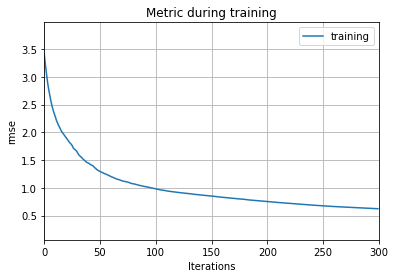

In [16]:
stationid_set = [0]
for station_id in stationid_set:
    train_X = main_df[main_df['station_id'] == station_id]
    train_learn = train_X[train_X['date'] < '2013-10-01']
    train_learn = train_learn[train_learn['date'] >= '2013-09-02']    
    train_learn_y = train_learn["bikes_available"]
    train_learn_x = train_learn.drop("station_id",axis=1)
    train_learn_x = train_learn_x.drop("date",axis=1)
    train_learn_x = train_learn_x.drop("bikes_available",axis=1)    

    train_lightgbm_set = lgb.Dataset(train_learn_x, train_learn_y)

    model = lgb.LGBMRegressor(objective='rmse', n_estimators = 300)
    model.fit(train_learn_x, train_learn_y, eval_set=[(train_learn_x, train_learn_y), (train_learn_x, train_learn_y)], verbose=10)

    lgb.plot_metric(model)

[10]	training's rmse: 2.34098
[20]	training's rmse: 1.91818
[30]	training's rmse: 1.66177
[40]	training's rmse: 1.45012
[50]	training's rmse: 1.30403
[60]	training's rmse: 1.2129
[70]	training's rmse: 1.13145
[80]	training's rmse: 1.07577
[90]	training's rmse: 1.02726
[100]	training's rmse: 0.985184
[110]	training's rmse: 0.94816
[120]	training's rmse: 0.91849
[130]	training's rmse: 0.896466
[140]	training's rmse: 0.872687
[150]	training's rmse: 0.851994
[160]	training's rmse: 0.82911
[170]	training's rmse: 0.809178
[180]	training's rmse: 0.793007
[190]	training's rmse: 0.771504
[200]	training's rmse: 0.754489
[210]	training's rmse: 0.736449
[220]	training's rmse: 0.721356
[230]	training's rmse: 0.705902
[240]	training's rmse: 0.690003
[250]	training's rmse: 0.676122
[260]	training's rmse: 0.663366
[270]	training's rmse: 0.653023
[280]	training's rmse: 0.643064
[290]	training's rmse: 0.632699
[300]	training's rmse: 0.622721
[10]	training's rmse: 1.63713
[20]	training's rmse: 1.14412
[3

1.2822802066802979


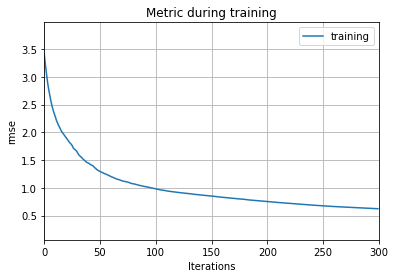

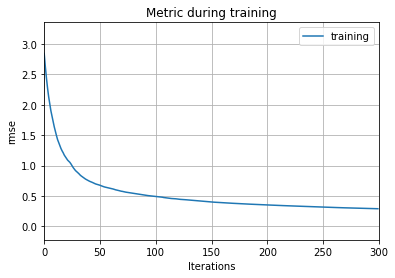

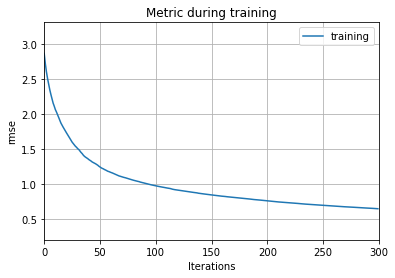

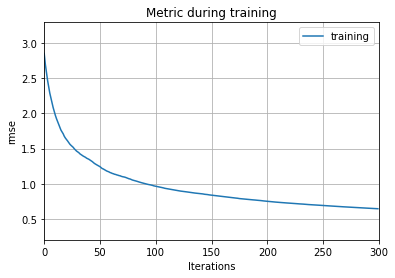

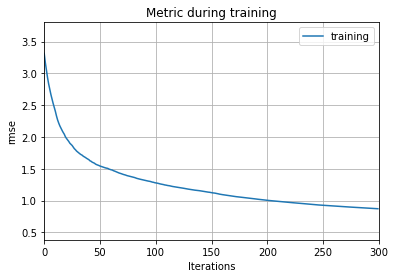

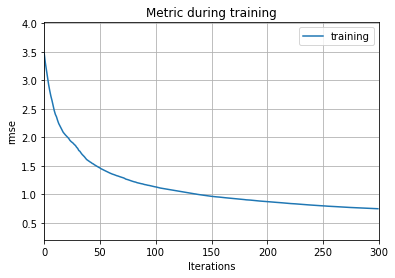

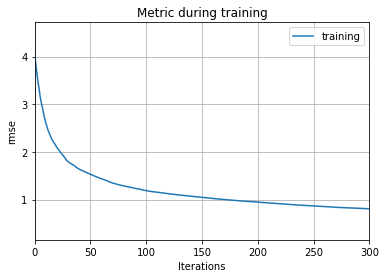

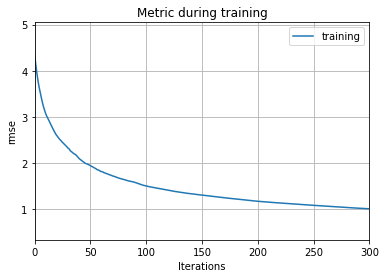

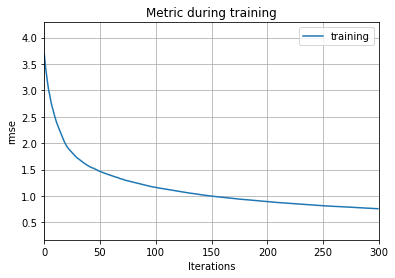

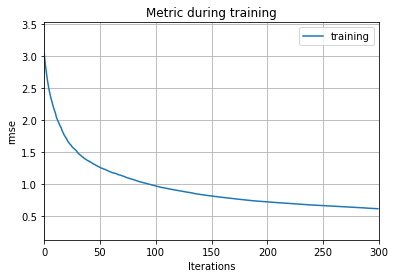

In [22]:
start = time.time()
for station_id in stationid_set:
    train_X = main_df[main_df['station_id'] == station_id]
    train_learn = train_X[train_X['date'] < '2013-10-01']
    train_learn = train_learn[train_learn['date'] >= '2013-09-02']
    train_learn_y = train_learn["bikes_available"]
    train_learn_x = train_learn.drop("station_id",axis=1)
    train_learn_x = train_learn_x.drop("date",axis=1)
    train_learn_x = train_learn_x.drop("bikes_available",axis=1)    

    train_lightgbm_set = lgb.Dataset(train_learn_x, train_learn_y)

    model = lgb.LGBMRegressor(objective='rmse', n_estimators = 300)
    model.fit(train_learn_x, train_learn_y, eval_set=[(train_learn_x, train_learn_y), (train_learn_x, train_learn_y)], verbose=10)

    lgb.plot_metric(model)

    pred_lightgbn_24 = model.predict(train_learn_x)    
    train_learn['predict_24'] = pred_lightgbn_24
    train_file_name = "lgb_24_predict/normal/lgb_train_stationid" + str(station_id) + "_201309.csv" 
    train_learn.to_csv(train_file_name)
      
    test = main_df[main_df['station_id'] == station_id][main_df['date'] < '2013-10-08']
    test = test[test['date'] >= '2013-10-01']
    test_y = test["bikes_available"]
    test_x = test.drop("station_id",axis=1)
    test_x = test_x.drop("date",axis=1)
    test_x = test_x.drop("bikes_available",axis=1)    
    pred_lightgbm_test = model.predict(test_x) 
    test['predict_24'] = pred_lightgbm_test
    test_file_name = "lgb_24_predict/normal/lgb_test_stationid" + str(station_id) + "_201309.csv" 
    test.to_csv(test_file_name)
elapsed_time = time.time() - start
print(elapsed_time)

[10]	training's rmse: 2.06742
[20]	training's rmse: 1.61889
[30]	training's rmse: 1.39951
[40]	training's rmse: 1.24081
[50]	training's rmse: 1.12527
[60]	training's rmse: 1.0418
[70]	training's rmse: 0.977917
[80]	training's rmse: 0.922574
[90]	training's rmse: 0.878844
[100]	training's rmse: 0.842278
[110]	training's rmse: 0.809347
[120]	training's rmse: 0.775727
[130]	training's rmse: 0.749997
[140]	training's rmse: 0.730199
[150]	training's rmse: 0.714161
[160]	training's rmse: 0.699523
[170]	training's rmse: 0.684879
[180]	training's rmse: 0.668174
[190]	training's rmse: 0.655026
[200]	training's rmse: 0.64241
[210]	training's rmse: 0.632554
[220]	training's rmse: 0.623305
[230]	training's rmse: 0.614185
[240]	training's rmse: 0.605346
[250]	training's rmse: 0.594774
[260]	training's rmse: 0.585313
[270]	training's rmse: 0.577398
[280]	training's rmse: 0.568
[290]	training's rmse: 0.5588
[300]	training's rmse: 0.552018
[10]	training's rmse: 1.13692
[20]	training's rmse: 0.724337
[

1.3342995643615723


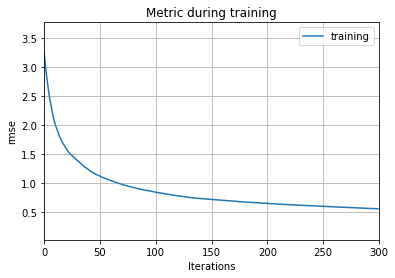

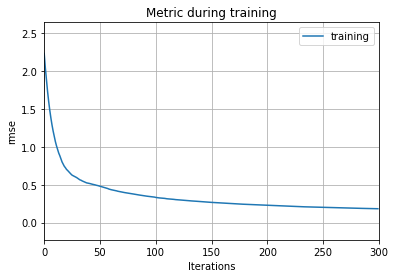

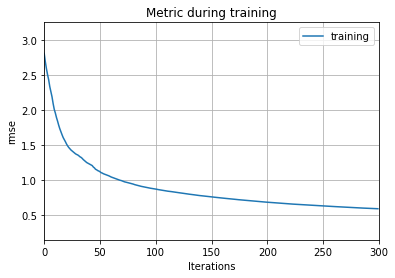

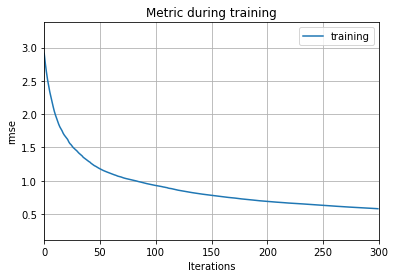

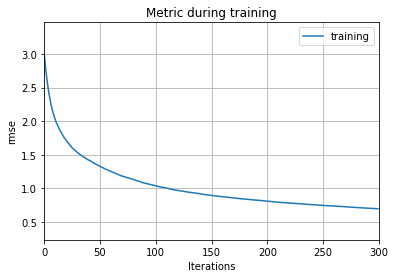

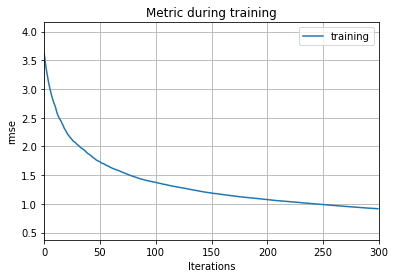

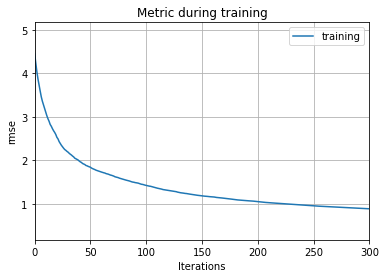

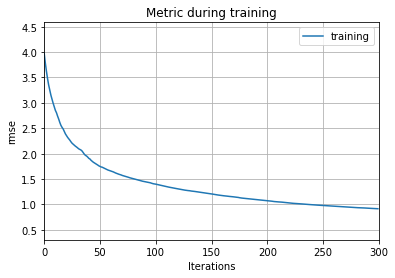

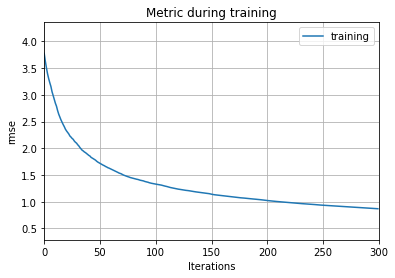

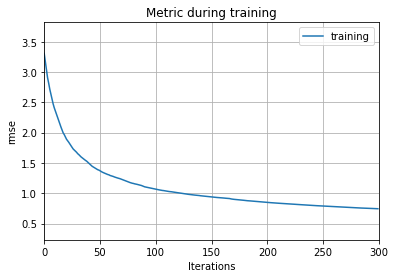

In [23]:
start = time.time()
for station_id in stationid_set:
    train_X = main_df[main_df['station_id'] == station_id]
    train_learn = train_X[train_X['date'] < '2014-02-01']
    train_learn = train_learn[train_learn['date'] >= '2014-01-02']
    train_learn_y = train_learn["bikes_available"]
    train_learn_x = train_learn.drop("station_id",axis=1)
    train_learn_x = train_learn_x.drop("date",axis=1)
    train_learn_x = train_learn_x.drop("bikes_available",axis=1)    

    train_lightgbm_set = lgb.Dataset(train_learn_x, train_learn_y)

    model = lgb.LGBMRegressor(objective='rmse', n_estimators = 300)
    model.fit(train_learn_x, train_learn_y, eval_set=[(train_learn_x, train_learn_y), (train_learn_x, train_learn_y)], verbose=10)

    lgb.plot_metric(model)

    pred_lightgbn_24 = model.predict(train_learn_x)    
    train_learn['predict_24'] = pred_lightgbn_24
    train_file_name = "lgb_24_predict/normal/lgb_train_stationid" + str(station_id) + "_201401.csv" 
    train_learn.to_csv(train_file_name)
      
    test = main_df[main_df['station_id'] == station_id][main_df['date'] < '2014-02-08']
    test = test[test['date'] >= '2014-02-01']
    test_y = test["bikes_available"]
    test_x = test.drop("station_id",axis=1)
    test_x = test_x.drop("date",axis=1)
    test_x = test_x.drop("bikes_available",axis=1)    
    pred_lightgbm_test = model.predict(test_x) 
    test['predict_24'] = pred_lightgbm_test
    test_file_name = "lgb_24_predict/normal/lgb_test_stationid" + str(station_id) + "_201401.csv" 
    test.to_csv(test_file_name)
elapsed_time = time.time() - start
print(elapsed_time)

[10]	training's rmse: 2.6788
[20]	training's rmse: 2.22379
[30]	training's rmse: 1.92395
[40]	training's rmse: 1.7183
[50]	training's rmse: 1.54682
[60]	training's rmse: 1.42658
[70]	training's rmse: 1.31729
[80]	training's rmse: 1.2399
[90]	training's rmse: 1.17424
[100]	training's rmse: 1.11815
[110]	training's rmse: 1.07466
[120]	training's rmse: 1.03792
[130]	training's rmse: 1.00121
[140]	training's rmse: 0.969982
[150]	training's rmse: 0.945387
[160]	training's rmse: 0.920503
[170]	training's rmse: 0.898251
[180]	training's rmse: 0.881073
[190]	training's rmse: 0.860389
[200]	training's rmse: 0.841199
[210]	training's rmse: 0.82507
[220]	training's rmse: 0.811439
[230]	training's rmse: 0.798511
[240]	training's rmse: 0.786664
[250]	training's rmse: 0.775614
[260]	training's rmse: 0.763837
[270]	training's rmse: 0.752554
[280]	training's rmse: 0.743079
[290]	training's rmse: 0.734361
[300]	training's rmse: 0.726431
[10]	training's rmse: 0.88015
[20]	training's rmse: 0.607955
[30]	

1.3423020839691162


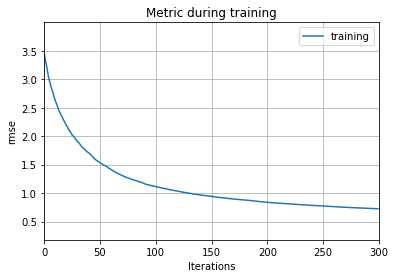

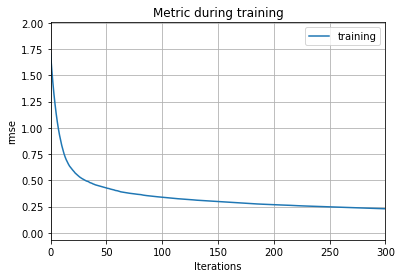

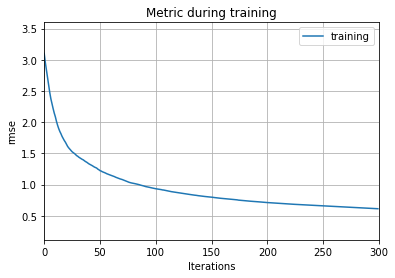

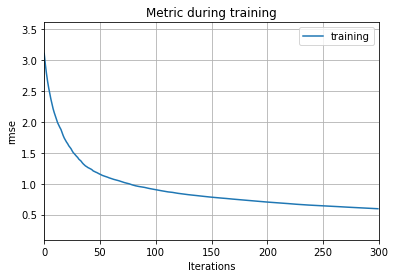

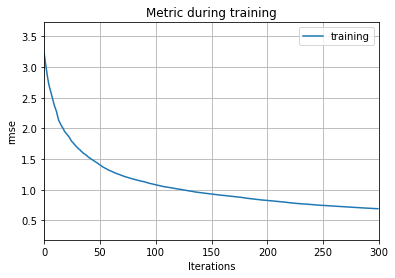

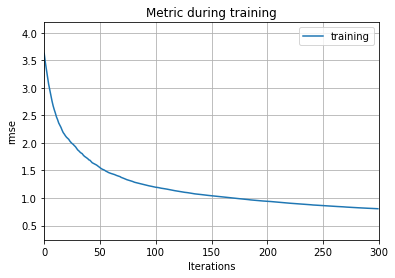

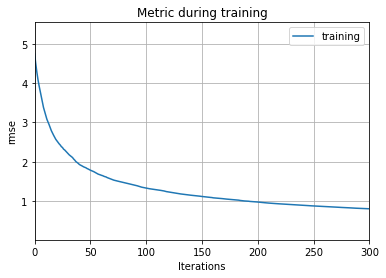

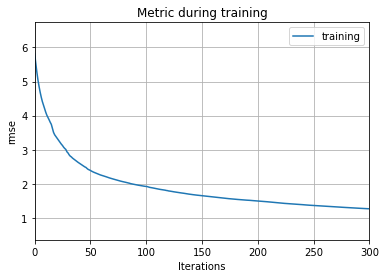

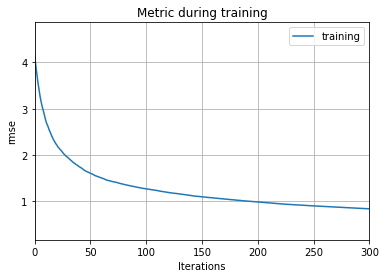

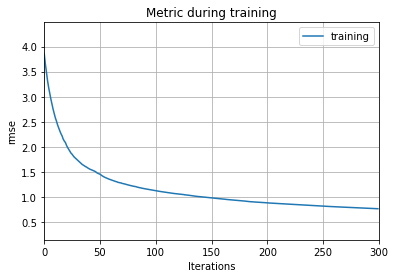

In [24]:
start = time.time()
for station_id in stationid_set:
    train_X = main_df[main_df['station_id'] == station_id]
    train_learn = train_X[train_X['date'] < '2014-06-01']
    train_learn = train_learn[train_learn['date'] >= '2014-05-02']
    train_learn_y = train_learn["bikes_available"]
    train_learn_x = train_learn.drop("station_id",axis=1)
    train_learn_x = train_learn_x.drop("date",axis=1)
    train_learn_x = train_learn_x.drop("bikes_available",axis=1)    

    train_lightgbm_set = lgb.Dataset(train_learn_x, train_learn_y)

    model = lgb.LGBMRegressor(objective='rmse', n_estimators = 300)
    model.fit(train_learn_x, train_learn_y, eval_set=[(train_learn_x, train_learn_y), (train_learn_x, train_learn_y)], verbose=10)

    lgb.plot_metric(model)

    pred_lightgbn_24 = model.predict(train_learn_x)    
    train_learn['predict_24'] = pred_lightgbn_24
    train_file_name = "lgb_24_predict/normal/lgb_train_stationid" + str(station_id) + "_201405.csv" 
    train_learn.to_csv(train_file_name)
      
    test = main_df[main_df['station_id'] == station_id][main_df['date'] < '2014-06-08']
    test = test[test['date'] >= '2014-06-01']
    test_y = test["bikes_available"]
    test_x = test.drop("station_id",axis=1)
    test_x = test_x.drop("date",axis=1)
    test_x = test_x.drop("bikes_available",axis=1)    
    pred_lightgbm_test = model.predict(test_x) 
    test['predict_24'] = pred_lightgbm_test
    test_file_name = "lgb_24_predict/normal/lgb_test_stationid" + str(station_id) + "_201405.csv" 
    test.to_csv(test_file_name)
elapsed_time = time.time() - start
print(elapsed_time)

[10]	training's rmse: 2.00442
[20]	training's rmse: 1.54231
[30]	training's rmse: 1.2854
[40]	training's rmse: 1.11979
[50]	training's rmse: 0.998467
[60]	training's rmse: 0.901948
[70]	training's rmse: 0.825373
[80]	training's rmse: 0.761505
[90]	training's rmse: 0.710802
[100]	training's rmse: 0.664467
[110]	training's rmse: 0.621219
[120]	training's rmse: 0.583469
[130]	training's rmse: 0.551388
[140]	training's rmse: 0.521829
[150]	training's rmse: 0.494458
[160]	training's rmse: 0.470491
[170]	training's rmse: 0.446451
[180]	training's rmse: 0.424148
[190]	training's rmse: 0.404511
[200]	training's rmse: 0.388786
[210]	training's rmse: 0.371365
[220]	training's rmse: 0.358091
[230]	training's rmse: 0.344892
[240]	training's rmse: 0.332135
[250]	training's rmse: 0.320974
[260]	training's rmse: 0.309838
[270]	training's rmse: 0.297779
[280]	training's rmse: 0.287538
[290]	training's rmse: 0.278765
[300]	training's rmse: 0.269193
[10]	training's rmse: 0.782933
[20]	training's rmse: 0

[10]	training's rmse: 2.01413
[20]	training's rmse: 1.43548
[30]	training's rmse: 1.21405
[40]	training's rmse: 1.06691
[50]	training's rmse: 0.959099
[60]	training's rmse: 0.8696
[70]	training's rmse: 0.792608
[80]	training's rmse: 0.730471
[90]	training's rmse: 0.674168
[100]	training's rmse: 0.623015
[110]	training's rmse: 0.577754
[120]	training's rmse: 0.536539
[130]	training's rmse: 0.503052
[140]	training's rmse: 0.468562
[150]	training's rmse: 0.439158
[160]	training's rmse: 0.413663
[170]	training's rmse: 0.391568
[180]	training's rmse: 0.369984
[190]	training's rmse: 0.348811
[200]	training's rmse: 0.328546
[210]	training's rmse: 0.311571
[220]	training's rmse: 0.294611
[230]	training's rmse: 0.280308
[240]	training's rmse: 0.266585
[250]	training's rmse: 0.254753
[260]	training's rmse: 0.242658
[270]	training's rmse: 0.231155
[280]	training's rmse: 0.221597
[290]	training's rmse: 0.21224
[300]	training's rmse: 0.203339
12.839022636413574


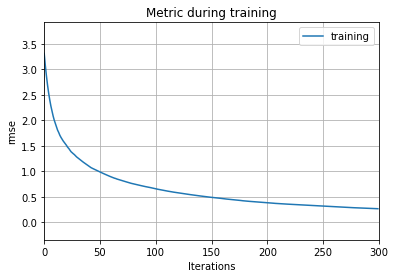

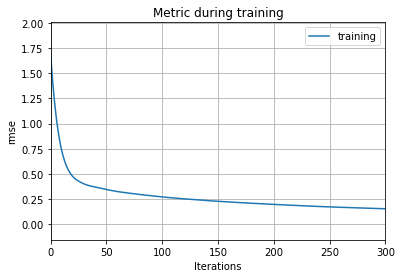

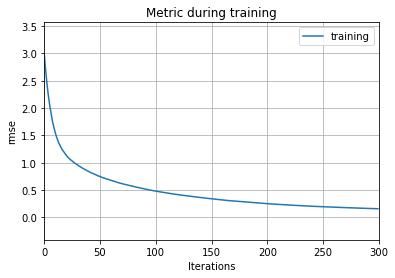

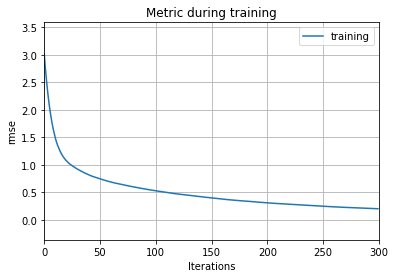

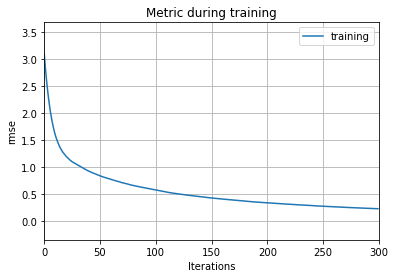

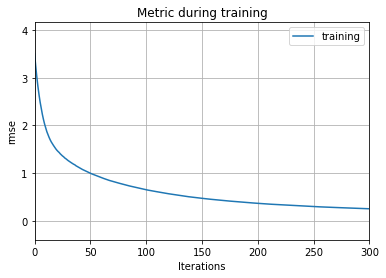

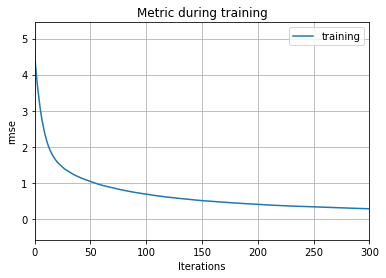

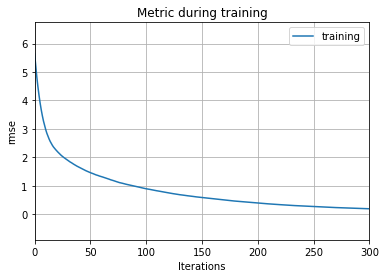

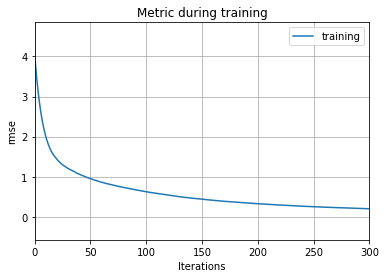

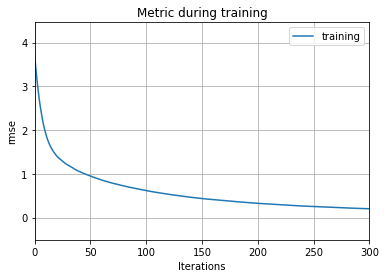

In [27]:
start = time.time()
for station_id in stationid_set:
    train_X = main_df[main_df['station_id'] == station_id]
    train_lag = train_X[train_X['date'] < '2014-06-01']
    train_lag = train_lag[train_lag['date'] >= '2014-05-01']['bikes_available']
    train_learn = train_X[train_X['date'] < '2014-06-01']
    train_learn = train_learn[train_learn['date'] >= '2014-05-02']
    
    i = 1
    while i < 25:
        row_name = "lag_" + str(i) + "hour"
        set = train_lag[24-i:744-i]
        train_learn[row_name] = set.values
        i += 1
    i = 0    
    
    train_learn_y = train_learn["bikes_available"]
    train_learn_x = train_learn.drop("station_id",axis=1)
    train_learn_x = train_learn_x.drop("date",axis=1)
    train_learn_x = train_learn_x.drop("bikes_available",axis=1)    
    train_lightgbm_set = lgb.Dataset(train_learn_x, train_learn_y)

    model = lgb.LGBMRegressor(objective='rmse', n_estimators = 300)
    model.fit(train_learn_x, train_learn_y, eval_set=[(train_learn_x, train_learn_y), (train_learn_x, train_learn_y)], verbose=10)

    lgb.plot_metric(model)

    pred_lightgbn_24 = model.predict(train_learn_x)    
    train_learn['predict_24'] = pred_lightgbn_24
    train_file_name = "lgb_24_predict/gomi/lgb_train_stationid" + str(station_id) + "_201405.csv" 
    train_learn.to_csv(train_file_name)
    
    test_lag = main_df[main_df['station_id'] == station_id][main_df['date'] < '2014-06-01']
    test_lag = test_lag[test_lag['date'] >= '2014-05-31']['bikes_available']     
    test = main_df[main_df['station_id'] == station_id][main_df['date'] < '2014-06-08']
    test = test[test['date'] >= '2014-06-01']
    test_y = test["bikes_available"]
    test_x = test.drop("station_id",axis=1)
    test_x = test_x.drop("date",axis=1)
    test_x = test_x.drop("bikes_available",axis=1)    

    pred_lightgbm_test = []
    len(pred_lightgbm_test)
    i=0
    while i < 168:
        test_x_line = test_x[i:i+1]

        lag = []
        for j in pred_lightgbm_test:
            lag.insert(0, j)

        for k in range(24 - len(pred_lightgbm_test)):
            lag.append(test_lag[23-k:24-k].values)
        s = 1
        while s < 25:
            row_name = "lag_" + str(s) + "hour"
            test_x_line[row_name] = lag[s-1]
            s += 1

        pred_lightgbm_test_lag_line = model.predict(test_x_line)
        pred_lightgbm_test =np.append(pred_lightgbm_test, pred_lightgbm_test_lag_line)
        i += 1

    test['predict_24'] = pred_lightgbm_test
    test_file_name = "lgb_24_predict/gomi/lgb_test_stationid" + str(station_id) + "_201405.csv" 
    test.to_csv(test_file_name)

elapsed_time = time.time() - start
print(elapsed_time)

In [4]:
#2013年10月予測　時間計測
start = time.time()
for station_id in stationid_set:
    train_X = main_df[main_df['station_id'] == station_id]
    train_lag = train_X[train_X['date'] < '2013-10-01']['bikes_available']

    train_learn = train_X[train_X['date'] < '2013-10-01']
    train_learn = train_learn[train_learn['date'] >= '2013-09-02']
    
    i = 1
    while i < 25:
        row_name = "lag_" + str(i) + "hour"
        set = train_lag[24-i:720-i]
        train_learn[row_name] = set.values
        i += 1
    i = 0    
    
    train_learn_y = train_learn["bikes_available"]
    train_learn_x = train_learn.drop("station_id",axis=1)
    train_learn_x = train_learn_x.drop("date",axis=1)
    train_learn_x = train_learn_x.drop("bikes_available",axis=1)    

    train_lightgbm_set = lgb.Dataset(train_learn_x, train_learn_y)

    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "verbose" : -1
    }

    lgb_model_24 = lgb.train(
        params = params,
        train_set = train_lightgbm_set,
        valid_sets = [train_lightgbm_set, train_lightgbm_set],
        num_boost_round = 300,
        early_stopping_rounds=10,
        verbose_eval=5
    )

    pred_lightgbn_24 = lgb_model_24.predict(train_learn_x)    
#    train_learn['predict_24'] = pred_lightgbn_24
#    train_file_name = "lgb_24_predict/lgb_train_stationid" + str(station_id) + "_201309.csv" 
#    train_learn.to_csv(train_file_name)
    
    test_lag = main_df[main_df['station_id'] == station_id][main_df['date'] < '2013-10-01']
    test_lag = test_lag[test_lag['date'] >= '2013-09-30']['bikes_available']     
    test = main_df[main_df['station_id'] == station_id][main_df['date'] < '2013-10-08']
    test = test[test['date'] >= '2013-10-01']
    test_y = test["bikes_available"]
    test_x = test.drop("station_id",axis=1)
    test_x = test_x.drop("date",axis=1)
    test_x = test_x.drop("bikes_available",axis=1)    

    pred_lightgbm_test = []
    i=0
    while i < 168:
        test_x_line = test_x[i:i+1]

        lag = []
        for j in pred_lightgbm_test:
            lag.insert(0, j)

        for k in range(24 - len(pred_lightgbm_test)):
            lag.append(test_lag[23-k:24-k].values)
        s = 1
        while s < 25:
            row_name = "lag_" + str(s) + "hour"
            test_x_line[row_name] = lag[s-1]
            s += 1

        pred_lightgbm_test_lag_line = lgb_model_24.predict(test_x_line)
        pred_lightgbm_test =np.append(pred_lightgbm_test, pred_lightgbm_test_lag_line)
        i += 1

#    test['predict_24'] = pred_lightgbm_test
#    test_file_name = "lgb_24_predict/lgb_test_stationid" + str(station_id) + "_201309.csv" 
#    test.to_csv(test_file_name)
elapsed_time = time.time() - start
print(elapsed_time)

Training until validation scores don't improve for 10 rounds
[5]	training's rmse: 2.42855
[10]	training's rmse: 1.78667
[15]	training's rmse: 1.46332
[20]	training's rmse: 1.28601
[25]	training's rmse: 1.18324
[30]	training's rmse: 1.10769
[35]	training's rmse: 1.03
[40]	training's rmse: 0.965107
[45]	training's rmse: 0.913966
[50]	training's rmse: 0.873358
[55]	training's rmse: 0.836865
[60]	training's rmse: 0.802343
[65]	training's rmse: 0.771873
[70]	training's rmse: 0.744371
[75]	training's rmse: 0.718695
[80]	training's rmse: 0.693518
[85]	training's rmse: 0.67123
[90]	training's rmse: 0.648692
[95]	training's rmse: 0.627894
[100]	training's rmse: 0.610155
[105]	training's rmse: 0.592402
[110]	training's rmse: 0.577365
[115]	training's rmse: 0.561586
[120]	training's rmse: 0.547505
[125]	training's rmse: 0.533033
[130]	training's rmse: 0.520466
[135]	training's rmse: 0.50669
[140]	training's rmse: 0.495402
[145]	training's rmse: 0.483371
[150]	training's rmse: 0.471449
[155]	train

Training until validation scores don't improve for 10 rounds
[5]	training's rmse: 2.48854
[10]	training's rmse: 1.86669
[15]	training's rmse: 1.54789
[20]	training's rmse: 1.36459
[25]	training's rmse: 1.25695
[30]	training's rmse: 1.1635
[35]	training's rmse: 1.09087
[40]	training's rmse: 1.02515
[45]	training's rmse: 0.964697
[50]	training's rmse: 0.912869
[55]	training's rmse: 0.867931
[60]	training's rmse: 0.830202
[65]	training's rmse: 0.78882
[70]	training's rmse: 0.754655
[75]	training's rmse: 0.719975
[80]	training's rmse: 0.688131
[85]	training's rmse: 0.66282
[90]	training's rmse: 0.63729
[95]	training's rmse: 0.612626
[100]	training's rmse: 0.591005
[105]	training's rmse: 0.569057
[110]	training's rmse: 0.548985
[115]	training's rmse: 0.529459
[120]	training's rmse: 0.512164
[125]	training's rmse: 0.495109
[130]	training's rmse: 0.478572
[135]	training's rmse: 0.462053
[140]	training's rmse: 0.445986
[145]	training's rmse: 0.429808
[150]	training's rmse: 0.416594
[155]	train

12.6817147731781
